In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch_geometric

from torch_geometric.utils import to_networkx
from torch_geometric.loader import NeighborLoader

import torch.nn.functional as F
from torch.nn import Linear, Dropout
from torch_geometric.nn import SAGEConv, GATConv, GATv2Conv, GCNConv, GlobalAttention
from torch_geometric.utils import dropout_edge

from torch_geometric.nn import global_mean_pool, global_max_pool, global_add_pool
from torch_geometric.data import DataLoader

import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys
import os
sys.path.insert(0, os.path.abspath('../../code/'))
from utils.graph_features import create_graph_dataset

In [3]:
import warrior as war

WARRIOR
   brain initialized
   network initialized


In [4]:
fcs = np.load('../local/fcs/sparse_fcs_100_unrelated.npy')
print(fcs.shape)
labels = np.load('../local/gender_labels/unrelated_gender_labels.npy')
print(labels.shape)

(852, 100, 100)
(852,)


In [5]:
N_GRAPHS = fcs.shape[0]
N_GRAPHS

852

In [6]:
PERCENT = 0.75 
N_TRAINING_SAMPLES = int(np.floor(PERCENT*N_GRAPHS))
N_TRAINING_SAMPLES, N_TRAINING_SAMPLES/N_GRAPHS

(639, 0.75)

In [7]:
root = '../local/graph_datasets/hcp/'
dataset = create_graph_dataset(sparse_fcs=fcs, root=root, labels=labels)

In [8]:
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

graph = dataset[0]
print()
print(f'First Graph: {graph}')
print('=============================================================')
print(f'Number of nodes: {graph.num_nodes}')
print(f'Number of edges: {graph.num_edges}')
print(f'Average node degree: {graph.num_edges / graph.num_nodes:.2f}')
print(f'Has isolated nodes: {graph.has_isolated_nodes()}')
print(f'Has self-loops: {graph.has_self_loops()}')
print(f'Is undirected: {graph.is_undirected()}')

Dataset: HCPDataset(852):
Number of graphs: 852
Number of features: 8
Number of classes: 2

First Graph: Data(x=[100, 8], edge_index=[2, 1332], edge_attr=[1332], y=[1])
Number of nodes: 100
Number of edges: 1332
Average node degree: 13.32
Has isolated nodes: False
Has self-loops: False
Is undirected: False


In [9]:
np.round(graph.x[:3,:].numpy(), 1)

array([[ 8. ,  8. ,  0. ,  4.4,  4.4,  0. ,  0. ,  0.7],
       [11. , 11. ,  0. ,  5.2,  5.2,  0. ,  0. ,  0.7],
       [25. , 22. ,  3. ,  9.3, 10.6, -1.3,  0.1,  0.5]], dtype=float32)

In [10]:
num_pos = sum(1 for data in dataset if data.y == 1)
num_neg = len(dataset) - num_pos
print(f'F:{num_pos} M:{num_neg} - {num_neg/num_pos:.3f}')

F:446 M:406 - 0.910


In [11]:
dataset_shuffled = dataset.shuffle()

train_dataset = dataset_shuffled[:N_TRAINING_SAMPLES]
test_dataset = dataset_shuffled[N_TRAINING_SAMPLES:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 639
Number of test graphs: 213


In [12]:
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)#, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)#, shuffle=False)
# for step, data in enumerate(train_loader):
#     print(f'Step {step + 1}:')
#     print('=======')
#     print(f'Number of graphs in the current batch: {data.num_graphs}')
#     print(data)
#     print(f'Graphs to aggregate: {len(np.unique(data.batch))}')
#     print(np.unique(data.batch))
#     print()

In [13]:
class AttentionGNN(nn.Module):
    def __init__(self, hidden_channels, num_heads=1, dropout=0.5):
        super(AttentionGNN, self).__init__()

        self.conv1 = SAGEConv(dataset.num_node_features, hidden_channels) # SAGEConv, GATConv, GATv2Conv, GCNConv
        #self.conv1 = GATConv(in_dim, hidden_channels, heads=num_heads, concat=True)#, dropout=dropout)
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)
        self.dropout1 = torch.nn.Dropout(0.7)
        self.relu1 = nn.ReLU()
        
        # Attention-based graph-level aggregation
        self.attention_weights = nn.Parameter(torch.Tensor(hidden_channels * num_heads, 1))
        nn.init.xavier_uniform_(self.attention_weights)  # Initialize attention weight

        # Final classifier
        self.classifier = nn.Linear(hidden_channels * num_heads, 1)

    def forward(self, x, edge_index, batch):

        node_embeddings = self.conv1(x, edge_index)
        node_embeddings = self.bn1(node_embeddings)
        node_embeddings = self.relu1(node_embeddings)
        node_embeddings = self.dropout1(node_embeddings)

        # Step 2: Compute attention scores for each node in the graph
        attention_scores = torch.matmul(node_embeddings, self.attention_weights)  # (num_nodes, 1)
        attention_scores = torch.sigmoid(attention_scores)  # Normalize scores to [0,1]
        
        # Step 3: Compute graph embedding as weighted sum of node embeddings
        weighted_embeddings = node_embeddings * attention_scores  # (num_nodes, hidden_dim * num_heads)
        graph_embedding = global_add_pool(weighted_embeddings, batch)  # (num_graphs, hidden_dim * num_heads)

        # Step 4: Compute logits for binary classification
        logits = self.classifier(graph_embedding)  # (num_graphs, 1)
        
        return logits, attention_scores  # Return logits and node attention scores


In [14]:
def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         data = data.to(device)
         optimizer.zero_grad()
         #print(f'Graphs in batch: {data.num_graphs}') 
         #print(f'data: {data}')
         y_logits,_ = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         #print(y_logits.shape)
        
         #print(f'y_hat:{out.shape}')
         #print(out)
         y_logits = y_logits.to(device)
         loss = criterion(y_logits.float(), torch.unsqueeze(data.y.float().to(device),1))  # Compute the loss.
         loss.backward()  # Derive gradients.
         #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # # Prevent exploding gradients by clipping
         optimizer.step()  # Update parameters based on gradients.
         #optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         data = data.to(device)
         y_logits,_ = model(data.x, data.edge_index, data.batch)
         y_probs = torch.sigmoid(y_logits)
         y_pred = (y_probs > 0.5).float()
         y_pred = y_pred.to(device)
         correct += int((y_pred.squeeze() == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.

In [15]:
2**np.arange(10)

array([  1,   2,   4,   8,  16,  32,  64, 128, 256, 512])

In [16]:
EPOCHS = 15001
metrics = np.empty((2,EPOCHS))

model = AttentionGNN(hidden_channels=128)
optimizer = torch.optim.AdamW(model.parameters(),lr=0.0005,  weight_decay=1e-4, amsgrad=True)
#criterion = torch.nn.CrossEntropyLoss()
criterion = nn.BCEWithLogitsLoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = model.to(device)

for epoch in range(EPOCHS):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    metrics[0,epoch] = train_acc
    metrics[1,epoch] = test_acc

    if epoch % 500 == 0:
        print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

cuda
Epoch: 000, Train Acc: 0.5524, Test Acc: 0.5822
Epoch: 500, Train Acc: 0.6526, Test Acc: 0.5915
Epoch: 1000, Train Acc: 0.6776, Test Acc: 0.5728
Epoch: 1500, Train Acc: 0.6635, Test Acc: 0.6009
Epoch: 2000, Train Acc: 0.7136, Test Acc: 0.5869
Epoch: 2500, Train Acc: 0.7293, Test Acc: 0.5634
Epoch: 3000, Train Acc: 0.7199, Test Acc: 0.5681
Epoch: 3500, Train Acc: 0.7496, Test Acc: 0.5634
Epoch: 4000, Train Acc: 0.7543, Test Acc: 0.5681
Epoch: 4500, Train Acc: 0.7606, Test Acc: 0.5962
Epoch: 5000, Train Acc: 0.7621, Test Acc: 0.5962
Epoch: 5500, Train Acc: 0.7621, Test Acc: 0.5869
Epoch: 6000, Train Acc: 0.7919, Test Acc: 0.6056
Epoch: 6500, Train Acc: 0.7997, Test Acc: 0.6150
Epoch: 7000, Train Acc: 0.8013, Test Acc: 0.5822
Epoch: 7500, Train Acc: 0.7887, Test Acc: 0.6056
Epoch: 8000, Train Acc: 0.8013, Test Acc: 0.6056
Epoch: 8500, Train Acc: 0.7856, Test Acc: 0.6150
Epoch: 9000, Train Acc: 0.7950, Test Acc: 0.5869
Epoch: 9500, Train Acc: 0.7934, Test Acc: 0.6620
Epoch: 10000, Tra

(2, 15001)


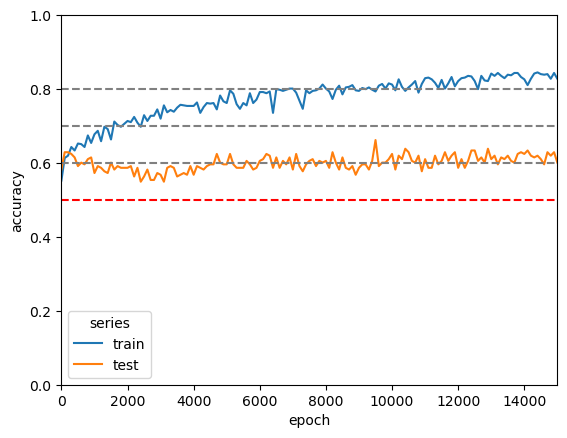

In [17]:
print(metrics.shape)
df = pd.DataFrame({'epoch': range(EPOCHS)[0::100], 'train': metrics[0,:][0::100], 'test': metrics[1,:][0::100]})
df_melted = df.melt(id_vars='epoch', var_name='series', value_name='accuracy')
sns.lineplot(x='epoch', y='accuracy', hue='series', data=df_melted)
plt.plot([0,EPOCHS],[0.5,0.5], c='r', linestyle='--')
plt.plot([0,EPOCHS],[0.6,0.6], c='gray', linestyle='--')
plt.plot([0,EPOCHS],[0.7,0.7], c='gray', linestyle='--')
plt.plot([0,EPOCHS],[0.8,0.8], c='gray', linestyle='--')
plt.xlim(0,EPOCHS)
plt.ylim(0,1)
plt.show()